## Cr√©ation et visualisation

### imports

In [1]:
import pickle

from graph_authors import run_random_separation, transitivity_by_category
from graph_authors import clean, create_csv, nonDirected_graph, distr_edges_weights, distr_nodes_degree, add_node_attribut_primary_cat
from graph_authors import edge_max, louvain_attribut, visualize_with_pyvis, density_hist_comm_size, are_little_comms_dense, are_big_comms_dense, mean_edges_weight
from graph_authors import first_analysis_giant_connected_component, plyvalent_authors_by_category, bridge_authors_by_centrality, leaders_by_category, analyze_distance_distributions

In [ ]:
import pandas as pd
df = pd.read_csv("articles.csv")


In [ ]:
math_cs_authors = df[df["category"].str.contains("math|cs", case=False, na=False)]["authors"] #len 1120542
math_authors = df[df["category"].str.contains("math.", case=False, na=False)]["authors"] #len 455866 
cs_authors = df[df["category"].str.contains("cs.", case=False, na=False)]["authors"] #len 455866
economy_authors = df[df["category"].str.contains("eco", case=False, na=False)]["authors"] #len 14794

### Cr√©er un dataset des articles en Statistiques, Maths, Economie et Data Science
C'est ce datatset qu'on va utiliser et analyser

In [ ]:
df_science = df[df["category"].str.contains("stat.|math.|econ.|cs.", case=False, na=False)
                & ~df["category"].str.contains("physics|cond-mat", case=False, na=False) & ~
                df["authors"].str.contains("Honghao", case=False, na=False)]
print(df_science.columns)
print(df_science.shape)
df_science.head()

Index(['id', 'title', 'summary', 'category', 'authors', 'published',
       'updated'],
      dtype='object')
(984439, 7)


id  \
12  http://arxiv.org/abs/2503.01843v2   
16  http://arxiv.org/abs/2502.21269v1   
31  http://arxiv.org/abs/2502.18964v1   
38  http://arxiv.org/abs/2502.18553v2   
66  http://arxiv.org/abs/2502.10390v1   

                                                title  \
12        When Can You Get Away with Low Memory Adam?   
16  Dynamical Decoupling of Generalization and Ove...   
31  Variational representation and estimates for t...   
38  Applications of Statistical Field Theory in De...   
66  (How) Can Transformers Predict Pseudo-Random N...   

                                              summary category  \
12  Adam is the go-to optimizer for training moder...    cs.LG   
16  The inductive bias and generalization properti...  stat.ML   
31  Random walks with a disordered self-interactio...  math.PR   
38  Deep learning algorithms have made incredible ...  stat.ML   
66  Transformers excel at discovering patterns in ...    cs.LG   

                                              authors             published  \
12  Dayal Singh Kalra, John Kirchenbauer, Maissam ...  2025-03-03T18:59:40Z   
16             Andrea Montanari, Pierfrancesco Urbani  2025-02-28T17:45:26Z   
31                                      Julien Poisat  2025-02-26T09:22:14Z   
38  Zohar Ringel, Noa Rubin, Edo Mor, Moritz Helia...  2025-02-25T18:19:06Z   
66  Tao Tao, Darshil Doshi, Dayal Singh Kalra, Tia...  2025-02-14T18:59:40Z   

                 updated  
12  2025-03-06T18:38:33Z  
16  2025-02-28T17:45:26Z  
31  2025-02-26T09:22:14Z  
38  2025-02-28T07:45:02Z  
66  2025-02-14T18:59:40Z

In [89]:
# Affiche le nombre de lignes o√π un nom appara√Æt plusieurs fois dans la m√™me liste d'auteurs
def has_duplicate_author(authors_str):
    authors = [a.strip() for a in authors_str.split(",")]
    return len(authors) != len(set(authors))

nb_duplicates = df["authors"].apply(has_duplicate_author).sum()
# Supprimer les lignes o√π un nom appara√Æt plusieurs fois dans la m√™me liste d'auteurs
mask_no_duplicates = ~df_science["authors"].apply(has_duplicate_author)
df_science = df_science[mask_no_duplicates]

# Supprimer les lignes avec des r√©sum√©s (summary) identiques (on garde la premi√®re occurrence)
df_science = df_science.drop_duplicates(subset="summary", keep="first")
print(f"Apr√®s nettoyage : {len(df_science)} lignes restantes.")


Apr√®s nettoyage : 694794 lignes restantes.


In [42]:
df_science.head(8)

id  \
12  http://arxiv.org/abs/2503.01843v2   
16  http://arxiv.org/abs/2502.21269v1   
31  http://arxiv.org/abs/2502.18964v1   
38  http://arxiv.org/abs/2502.18553v2   
66  http://arxiv.org/abs/2502.10390v1   
81  http://arxiv.org/abs/2502.07998v1   
84  http://arxiv.org/abs/2502.06739v1   
87  http://arxiv.org/abs/2502.05300v1   

                                                title  \
12        When Can You Get Away with Low Memory Adam?   
16  Dynamical Decoupling of Generalization and Ove...   
31  Variational representation and estimates for t...   
38  Applications of Statistical Field Theory in De...   
66  (How) Can Transformers Predict Pseudo-Random N...   
81  Adaptive kernel predictors from feature-learni...   
84  A note on the physical interpretation of neura...   
87  Parameter Symmetry Breaking and Restoration De...   

                                              summary category  \
12  Adam is the go-to optimizer for training moder...    cs.LG   
16  The inductive bias and generalization properti...  stat.ML   
31  Random walks with a disordered self-interactio...  math.PR   
38  Deep learning algorithms have made incredible ...  stat.ML   
66  Transformers excel at discovering patterns in ...    cs.LG   
81  Previous influential work showed that infinite...    cs.LG   
84  We highlight a formal and substantial analogy ...    cs.LG   
87  The dynamics of learning in modern large AI sy...    cs.LG   

                                              authors             published  \
12  Dayal Singh Kalra, John Kirchenbauer, Maissam ...  2025-03-03T18:59:40Z   
16             Andrea Montanari, Pierfrancesco Urbani  2025-02-28T17:45:26Z   
31                                      Julien Poisat  2025-02-26T09:22:14Z   
38  Zohar Ringel, Noa Rubin, Edo Mor, Moritz Helia...  2025-02-25T18:19:06Z   
66  Tao Tao, Darshil Doshi, Dayal Singh Kalra, Tia...  2025-02-14T18:59:40Z   
81  Clarissa Lauditi, Blake Bordelon, Cengiz Pehlevan  2025-02-11T22:34:49Z   
84                                        Sauro Succi  2025-02-10T18:07:51Z   
87  Liu Ziyin, Yizhou Xu, Tomaso Poggio, Isaac Chuang  2025-02-07T20:10:05Z   

                 updated  
12  2025-03-06T18:38:33Z  
16  2025-02-28T17:45:26Z  
31  2025-02-26T09:22:14Z  
38  2025-02-28T07:45:02Z  
66  2025-02-14T18:59:40Z  
81  2025-02-11T22:34:49Z  
84  2025-02-10T18:07:51Z  
87  2025-02-07T20:10:05Z

### Create a CSV with collaboration authors from stats, maths, computer science and economy
Columns: "author1", "author2", "weight", "category"

In [ ]:
create_csv("science_collaboration_cat&wight.csv", df_science)

CSV sauvegard√© sous ¬´‚ÄØscience_collaboration_cat&wight.csv‚ÄØ¬ª


### Create a networks non directed graph of a csv authors
    - fonction qui cr√©e le graph
    - histogramme de la distrubution du poids des arr√™tes
    - histogramme de la distribution des degr√©s des noeuds (somme des poids de ses arr√™tes)


In [ ]:
#Graph with all the authors (even if they have only one collaboration)
G_science= nonDirected_graph("science_collaboration_cat&wight.csv", filter_weight=0) 


# Save the object graph in a pickle file for later use
with open('G_science.pkl', 'wb') as f:
    pickle.dump(G_science, f)

Number of nodes: 581712
Number of edges: 3195437


In [102]:
print(f"Number of nodes: {G_science.number_of_nodes()}")
print(f"Number of edges: {G_science.number_of_edges()}")

Number of nodes: 581712
Number of edges: 3195437


In [2]:
import pickle

with open('G_science.pkl', 'rb') as f:
    G_science = pickle.load(f) 

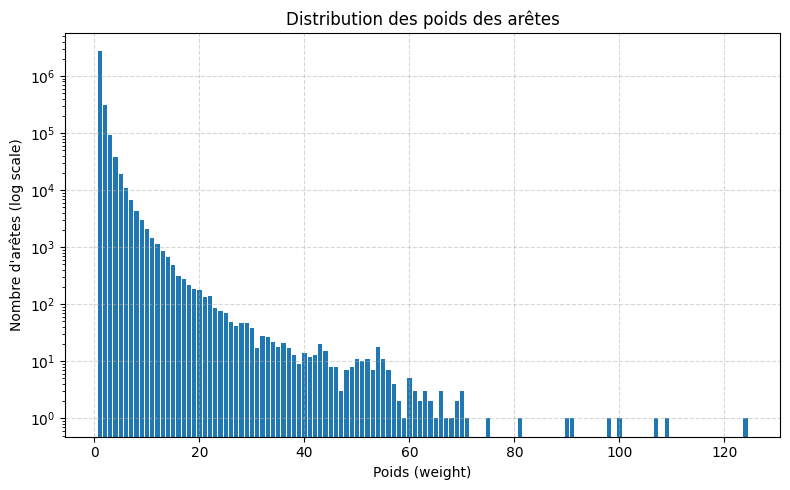

In [ ]:
distr_edges_weights(G_science)


Conlusion: essayer de trouver la structure simplifi√©e avec des arbres couvrants ne va pas √™tre coh√©rent coh√©rent puisque avec un **MST** on obtient le squelette qui relie tous les auteurs en passant syst√©matiquement par la collaboration la plus forte disponible √† chaque embranchement. Un auteur tr√®s connect√© ( la plupart de ses arr√™tes de poids >3) peut aspirer beaucoup de branches dans l‚Äôarbre, donnant une structure en √©toile trompeuse.
Suite: on va plutot chercher des structures de **communaut√©s et de centralit√©**


In [ ]:
distr_nodes_degree(G_science, w=False)

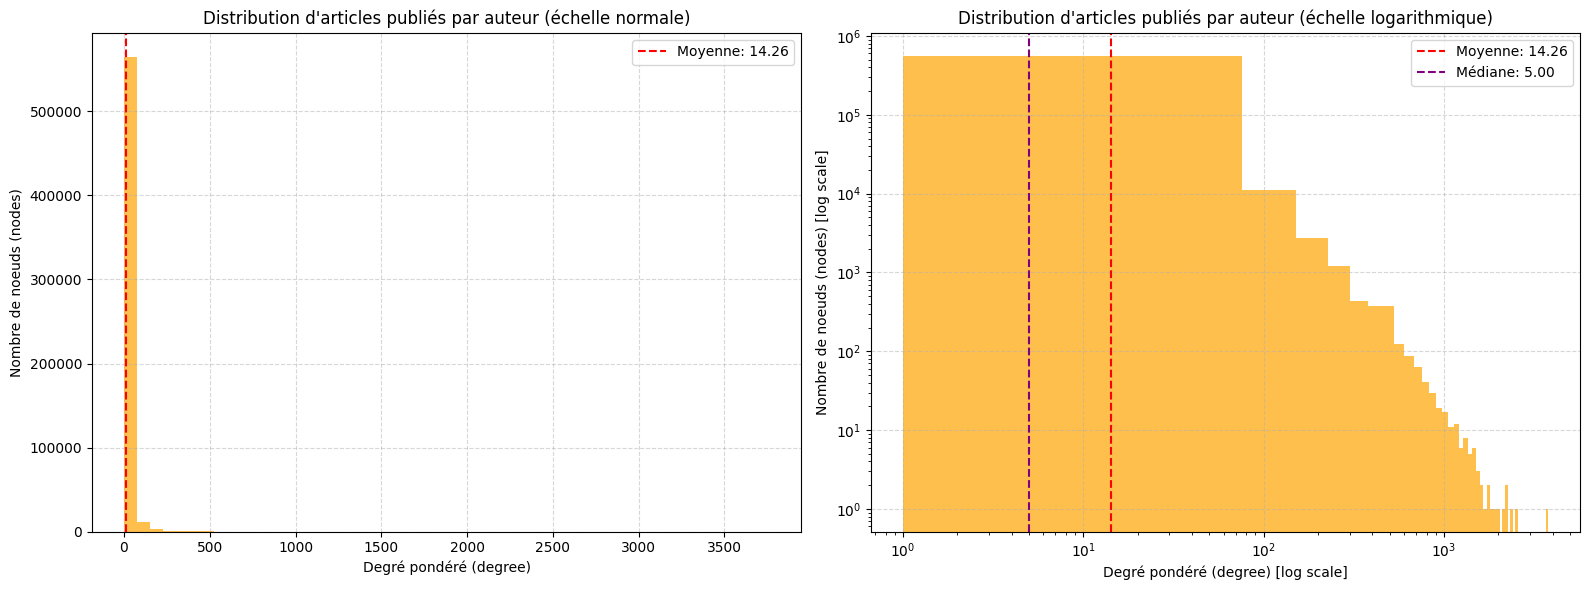

In [ ]:
distr_nodes_degree(G_science, w=True)

In [4]:
#Ajouter l'attribut primary_category √† tout les noeuds
primary_cat = add_node_attribut_primary_cat(G_science)

In [ ]:
edge_max(G_science)

Les deux auteurs connect√©s par l'ar√™te de poids maximal (124) sont : 'Ciriaco Andrea D'Angelo' et 'Giovanni Abramo'
Leur degr√©, c√†d le nombre de publications est : 230, 226
leur cat√©gorie principale:
cs cs


### Communaut√©s avec Louvain et cr√©ation d'un nouveau attribut

In [ ]:
communities, membership = louvain_attribut(G_science, res=1.0)


# Save the vraible communities in a pickle file for later use
with open('communities_list.pkl', 'wb') as f:
    pickle.dump(communities, f)

with open('membership_list.pkl', 'wb') as f:
    pickle.dump(membership, f)

Number of communities: 21062



- Build a node-->community mapping so that membership is a dict with all the 703614 nodes and each node
is asociated with its community (from 1 to 30890)

    - membership = {
    'John Kirchenbauer': 0,
    'Tom Goldstein': 0,
    'Inbar Seroussi':  1,
    .....
    'Blake Bordelo':   30890}

- Then we add a new node attribute called "louvain_community" to each node of the graph so that we can access to the community of each person like this 
    - G_science.nodes['Inbar Seroussi']['louvain_community']

In [ ]:
import pickle

with open('communities_list.pkl', 'rb') as f:
    communities = pickle.load(f) 
with open('memership_list.pkl', 'rb') as f:
    memership = pickle.load(f)

### Visualisation avec Pyvis (interactive)
Noeuds et edges seront colori√©s selon la communaut√© √† laquelle ils appartiennent

In [ ]:
G_maths =  nonDirected_graph("testpas_cs__petit_echantillon.csv", filter_weight=0) #testpas_cs__petit_echantillon.csv a 2100 lignes
communities_test, membership_test = louvain_attribut(G_maths, weight='weight', resolution=1.0) 
visualize_with_pyvis(G_maths, "maths_graph.html")

Number of nodes: 1877
Number of edges: 2100
maths_graph.html


<class 'pyvis.network.Network'> |N|=1877 |E|=2,100

## Structure

### Analysis of the created communities

In [ ]:
density_hist_comm_size(membership)

L‚Äôalgorithme de Louvain calcule la modularit√©, qui mesure la densit√© des liens au sein d‚Äôune communaut√© compar√©e √† celle entre communaut√©s. Lorsqu‚Äôelle n‚Äôaugmente plus, il regroupe les n≈ìuds d‚Äôune m√™me communaut√© en un super-n≈ìud. Le graphe est alors r√©duit √† un plus petit nombre de super-n≈ìuds, et on r√©p√®te ce processus it√©rativement jusqu‚Äô√† ce qu‚Äôaucune am√©lioration de la modularit√© ne soit possible.
- Analyse descriptive du graphique:
  - Un pic √©crasant sur la toute premi√®re barre (communaut√©s de taille 1 ou 2) : la **<span style="color: orange;">grande majorit√© des communaut√©s regroupent <10 auteurs**. Correspondent sans doute √† des bin√¥mes ou trin√¥mes de recherche tr√®s sp√©cialis√©s.
  - Une queue tr√®s longue : quelques dizaines de communaut√©s de taille interm√©diaire (quelques milliers d‚Äôauteurs).
  - **<span style="color: orange;">Deux grosses communaut√©s** en bout de queue (> 50 000 et > 90 000 n≈ìuds) qui concentrent **<span style="color: orange;">¬º du r√©seau**. On peut penser que ce ne sont pas des √©quipes de chercheurs soud√©es, ce sont des collaborations ponctuelles ou rares. Peut √™tre form√© de doctarants qui n‚Äôont collabor√© que quelques fois, leur carri√®re vient de commencer. Peut √™tre aussi de co-auteurs de publications massives, ils font partie de publications avec des dizaines d‚Äôauteurs, ils sont responsables d‚Äôune petite partie de l‚Äôarticle et ils n‚Äôont aucune relation avec la plupart des co-auteurs de l‚Äôarticle.
- On peut choisir la taille de nos communaut√©s via l‚Äôhyper-param√®tre ‚Äúr√©solution‚Äù
  - Valeurs plus √©lev√©es ‚Üí plus de communaut√©s, communaut√©s plus petites et plus serr√©es
  - Valeurs plus faibles ‚Üí moins de communaut√©s, plus grandes
    - Avec resolution = 1 on obtient 30 890 communaut√©s
    - Avec resolution = 0,5 on obtient 30 973 communaut√©s
    
- Ce r√©sultat semble bizarre, **<span style="color: orange;">on a diminu√© la r√©solution et pourtant il a cr√©e 83 communaut√©s de plus** (sur 31 000 communaut√©s ce nombre est n√©gligeable mais refl√®te la sensibilit√© de Louvain et nous montre encore une fois la sparsit√© et la dispersion de notre r√©seau.)
  - Dans notre cas, sur 30 000 communaut√©s, la quasi-totalit√© sont des micro-groupes de <10 noeuds, ils ne changent donc pas quel que soit la  r√©solution, puisqu‚Äôil n‚Äôy a pas assez de poids d‚Äôar√™tes pour justifier leur fusion
  - Seules quelques communaut√©s plus grandes bougent r√©ellement avec la r√©solution. Donc le nombre total de clusters reste √† peu pr√®s constant, et une variation de quelques dizaines est tout √† fait normale.
  - √Ä deux valeurs de de la r√©solution diff√©rentes, on peut tomber sur deux maxima locaux distincts, qui ne respectent pas forc√©ment une relation strictement monotone du nombre de clusters. On va v√©rifier cela en tra√ßant le nb de communaut√©s vs la r√©solution pour voir l'impacte du changement de la r√©solution.

- **Intuition sur la structure de notre graphe**:
    - graphe tr√®s h√©t√©rog√®ne¬†: beaucoup d‚Äôauteurs n‚Äôont qu‚Äôune ou deux collaborations.
    - Avec un **<span style="color: orange;">Œ≥ petit, deux n≈ìuds reli√©s par une seule ar√™te n‚Äôapportent pas assez de gain de modularit√©** pour √™tre fusionn√©s‚ÄØ; ils restent donc s√©par√©s ‚Üí **<span style="color: orange;">explosion du nombre de communaut√©s**.
    - Les communaut√©s ¬´‚ÄØr√©elles‚ÄØ¬ª (dens√©ment connect√©es) ne se forment qu‚Äô√† partir d‚Äôun certain seuil de Œ≥ o√π la fusion devient rentable.

- Piste: Augmenter la modularit√© pour capturer des communaut√©s plus faibles au sein de ce m√©ga-cluster ou bien faire le contraire, diminuer la modularit√© et essayer de rassembler dans des m√©ga-noeuds les petites commuaut√©s
Conclusion 2: √† compl√©ter quand j‚Äôaurais tourn√© Louvain avec une modularit√© plus basse


##### Analyse des profils d'auteurs dans les plus petites communaut√©s

In [3]:
communities, membership = louvain_attribut(G_science, res=1.0)

Number of communities: 21036


Nombre de petites communaut√©s (<10): 20223
Nombre de communaut√©s denses (densit√© > 0.99): 16638
Probabilit√© (fr√©quence) d'√™tre dense : 82.27%
threshold: 0.99


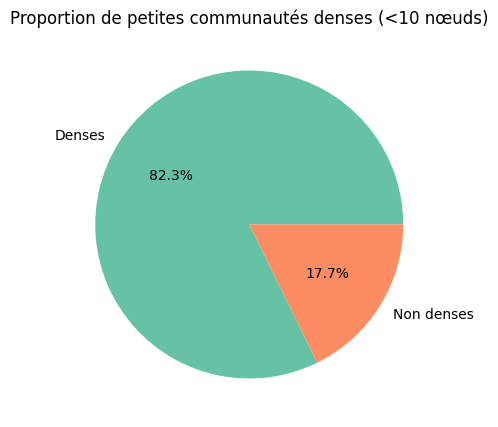

In [4]:
are_little_comms_dense(G_science,communities,membership, 0.99)

20 233/ 21 062 = 0.96. Donc **<span style="color: orange;">96% des communaut√©s ont moins de 10 auteurs**.

La densit√© d‚Äôun graphe (ou d‚Äôun sous-graphe) mesure √† quel point **ses n≈ìuds sont reli√©s entre eux comparativement au nombre maximal d‚Äôar√™tes possibles**. Pour ce graphe non orient√© de ùëõ n≈ìuds et ùëö ar√™tes, la densit√© ùõø est: 2m/(n(n-1))

- Si ùõø=0, il n‚Äôy a aucune connexion entre les n≈ìuds.
- Si ùõø=1, chaque n≈ìud est connect√© √† tous les autres (graphe complet).
   - Dans le graphique ci-dessus, **on consid√®re une communaut√© dense si ùõø>0.99**

**Interpr√©tationde notre r√©sultat**

Une communaut√© dense signifie que presque tous les auteurs de ce groupe interagissent directement entre eux.

√Ä l‚Äôinverse, une communaut√© peu dense regrouperait plut√¥t des auteurs qui ne collaborent que marginalement.

92% de nos petites communaut√©s Louvain sont denses, ce qui nous m√®ne √† penser que :

- Il y a un fort niveau de sp√©cialisation et coh√©sion, les auteurs au sein de chaque petite communaut√© partagent tr√®s probablement un m√™me champ de recherche tr√®s pointu. 
- Les membres d‚Äôune m√™me communaut√© ont des trajectoires et des centres d‚Äôint√©r√™t semblables (m√™me laboratoires, m√™mes m√©thodologies, m√™mes th√©matiques).
- Les communaut√©s sont des **r√©seaux ferm√©s** : l‚Äôinformation et les collaborations circulent surtout √† l‚Äôint√©rieur, avec peu d‚Äôouvertures vers l‚Äôext√©rieur.

0% de nos grandes communaut√©s Louvain sont denses avec threshold=0.5:
- La moiti√© des auteurs des communaut√©s ne sont pas connect√©s entre eux

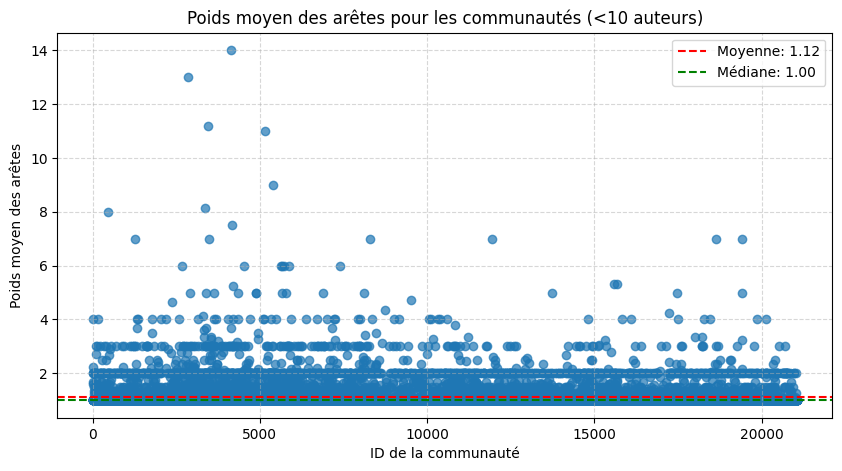

In [ ]:
# Calculer le poids moyen des ar√™tes pour les communaut√©s de plus de 100 auteurs
mean_edges_weight(G_science, communities, 10, little=True)

##### La plus grande communaut√©


Nombre de petites communaut√©s (<10): 111
Nombre de communaut√©s denses (densit√© > 0.99): 0
Probabilit√© (fr√©quence) d'√™tre dense : 0.00%
threshold: 0.99


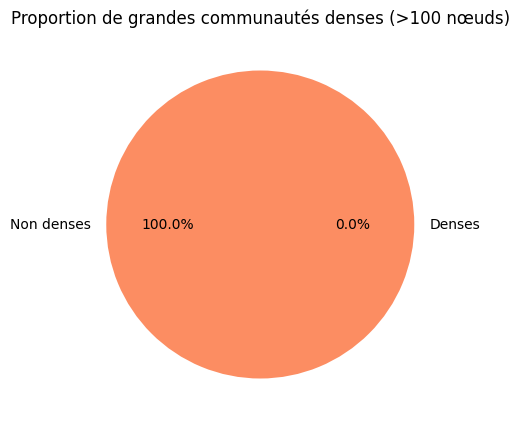

In [5]:
are_big_comms_dense(G_science, communities, membership, 0.5)

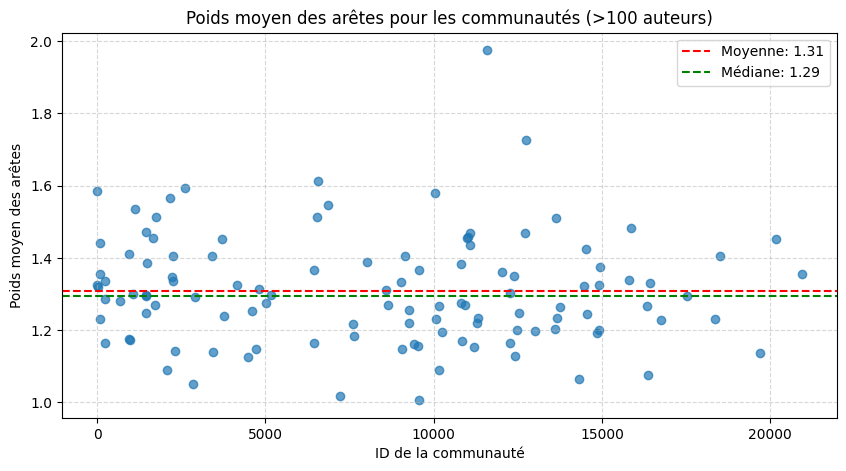

In [ ]:
mean_edges_weight(G_science, communities, 100, little=False)

Avec ces deux graphiques, onn rel√®ve une information tr√®s importante:
- Dans les petites comme dans les grandes communaut√©s, la moiti√© des ar√™tes ont poids 1, c√†d que la moiti√© des pairs d'auteurs n'ont collabor√© qu'une fois. Ceci est relev√© par la m√©diane.
- Or, dans les petites communaut√©s, la moyenne des poids varie entre 1 et 14. Ceci implique qu'au sein de certaines communaut√©s, les auteurs on collabor√© plus de 10 fois entre eux. Ce sont des communaut√©s plus denses, des collaborations qui dirent dans le temps et des √©quipes qui publient souvent ensemble
- Par contre, m√™me si la m√©diane reste la m√™me, la moyenne des poids dans les grandes communaut√©s ne varie que entre 1 et 1.8. Ceci indique que les grandes communaut√©s sont constitu√©es d'auteurs qui publient rarement ensemble. Ceci peut etre du √†:
   - des auteurs de machine learning puisque les articles de ce domaine ont souvent des dizaines d'auteurs
   - des auteurs jeunes qui n'ont que sa premi√®re publication sur Arkiv
   - des articles en preprint qui seront enlev√©s d√®s publication en magazine officielle et qui seront supprim√©s d'arkiv apr√®s

Ci-dessous on remarque que la communaut√© plus grande est compos√©e de 64 416 auteurs asiatiques

In [ ]:
# Trouver la communaut√© avec le plus de n≈ìuds
largest_community = max(communities, key=len)

# Afficher les auteurs de cette communaut√©
print(f"Nombre d'auteurs dans la plus grande communaut√© : {len(largest_community)}")
print("Auteurs dans la plus grande communaut√© :")
for author in largest_community:
    print(author)

Nombre d'auteurs dans la plus grande communaut√© : 64416
Auteurs dans la plus grande communaut√© :
Dahuang Liu
Todd Davies
Gang Zhao
Shaoshen Chen
Zhe Weng
Sergey Loyka
Huaicheng Yan
Zhangju Liu
Xiaoyan Fu
Daniel Graves
Yu-Chu Lin
Maram Kurdi
Shuai Yang
Shakhrul Iman Siam
Quanwei Lin
Kejiang Chen
Chong MO
Hok Wai Tsui
Xingye Kan
Hsiao-Chun Wu
Zongqian Li
Jean Yeh
Kartik K. Kansal
Hebo Ma
De Wen Soh
Augustus Hong
Yueheng Sun
Haofen Wang
Meiqi Feng
Yohsuke Shiiki
Mika H√§m√§l√§inen
Funing Hou
chunbo Cheng
Chetan Sharma
Yi Tian Xu
Peter Cederberg
Yunfei Song
Baoyi An
Kamran Turkoglu
Ruike Zhang
Inma Cobos
Raja Kushlanagar
Yajie Yang
Kaixin Gao
Diana M. Negoescu
Mingyi Liu
Aquib Iqbal
Jilin Zhao
shaoxing Qu
Yuan Su
Yulin Qiu
JianHuang Lai
Weiwei Ao
Jianlong Jin
John Bird
Jingyang Qiao
Enchao Gong
Shanhui Zhao
Ilija Ilievski
Fan Xing
Sen Nie
Thomas D. Pike
Alexander Heu√üner
Varun Vasudevan
Feisi Fu
Pengfei Yan
Mircea Stan
Qingchun Bai
Euiyong Park
Yuxuan Bian
Yuequn Li
Xintong Han
Xiaoli D

In [14]:
import random

# `communities` is my list of sets from louvain_communities
n_comms = len(communities)

# 1. Pick 3 distinct community indices
chosen_ids = random.sample(range(n_comms), 6)

for cid in chosen_ids:
    comm_nodes = list(communities[cid])
    # 2. Sample up to 20 authors (if the community has fewer than 20 nodes, sample all)
    sample_authors = random.sample(comm_nodes, min(20, len(comm_nodes)))
    # 3. Print them
    print(f"\nCommunity #{cid} (size {len(comm_nodes)}):")
    for a in sample_authors:
        print("  ", a, ":", G_science.nodes[a]['primary_category'])



Community #10112 (size 9):
   Hans Zachary N : cs
   Sharma Anuj : cs
   Neal R : cs
   Ravichandra-Mouli Varsha : cs
   Kandiboina Raghupathi : cs
   Knickerbocker Skylar : cs
   Kojo Adu-Gyamfi : cs
   Hawkins : cs
   Adu-Gyamfi Kojo : cs

Community #3373 (size 2):
   A. P. Starovoitov : math
   I. V. Kruglikov : math

Community #2077 (size 2):
   Francisco Redelico : stat
   Francisco Traversaro : stat

Community #17138 (size 4):
   Robert Akinie : cs
   John Kelly : cs
   Nana Kankam Brym Gyimah : cs
   Mansi Bhavsar : cs

Community #16210 (size 4):
   Swati Chowdhuri : cs
   Samadrita Karmakar : cs
   Satadip Saha : cs
   Ankur Chanda : cs

Community #13531 (size 3):
   Gordan Krekovic : cs
   Dejan Grba : cs
   Antonio Poscic : cs


- Community #10475 (size 3):
    - A M Mathai: indian, McGill University 
    - Joy Jacob: indian, Cochin University of Science & Technology
    - Sebastian George: indian, Kannur University

- Community #30570 (size 4):
    - Kiran Mantripragada: Indian, Ontario Tech University‚Äã
    - Shima Rezasoltani: Iranian, Ontario Tech University‚Äã
    - Faisal Z. Qureshi: Pakistani, Ontario Tech University‚Äã
    - Soham Chitnis: Indian, New York University

- Community #12908 (size 3):
    - Delphine Boucher: French, University of Rennes 1‚Äã
    - F√©lix Ulmer: French, University of Rennes 1‚Äã
    - Willi Geiselmann: German, Karlsruhe Institute of Technology

- Community #30765 (size 2):
    - Matthew Barth: American, University of California, Riverside‚Äã
    - Saswat Priyadarshi Nayak: Indian, University of California, Riverside‚Äã

- Community #14505 (size 12):
    - S. Pfenninger: Swiss, Delft University of Technology ‚Äã
    - S. Zachary: Information not found‚Äã
    - I. Staffell: British, Imperial College London ‚Äã
    - K. Schell: American, University of San Francisco ‚Äã
    - S. H. Tindemans: Dutch, Delft University of Technology ‚Äã
    - M. Lynch: American, Arizona State University ‚Äã
    - H. Zareipour: Canadian, University of Calgary ‚Äã
    - A. L. Wilson: American, University of Tennessee ‚Äã
    - S. Awara: American, National Renewable Energy Laboratory ‚Äã
    - R. Sioshansi: American, Carnegie Mellon University ‚Äã
    - C. J. Dent: Information not found‚Äã
    - N. Samaan: American, Pacific Northwest National Laboratory

- Community #47 (size 2):
    - S. Nechaev: Russian, Lomonosov Moscow State University ‚Äã
    - K. Polovnikov: Russian, Lomonosov Moscow State University

- Community #15142 (size 13):
    - Grylia Yaneth Chata Iscarra: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Josefh J. Quispe-Morales: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Nadine Aceituno-Moya: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Lindell Dennis Vilca-Mamani: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Cliver W. Vilca-Tinta: Peruvian, Universidad Nacional del Altiplano ‚Äã
    - Henry Juarez-Vargas: Peruvian, Universidad Nacional del Altiplano ‚Äã
    - Yhack Bryan Aycaya-Paco: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Wladimir A. Carlosviza-Amanqui: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Luz B. Valenzuela-Narvaez: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Roger Mijael Mansilla-Huanacuni: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Tony Gabriel-Fernandez Cayo: Peruvian, Universidad Nacional del Altiplano‚Äã
    - Rubi Melania Coasaca Callacondo: Peruvian, Universidad Nacional del Altiplano

Ainsi, nous pouvons clairement voir que les communaut√©s ont regroup√© des personnes du m√™me pays, qui recherchent dans le m√™me domaine, mais aussi que les personnes d'une m√™me communaut√© proviennent souvent de la m√™me universit√© (cette derni√®re information a √©t√© recherch√©e sur Internet car l'universit√© ou le pays ne sont pas des informations pr√©sentes dans la base de donn√©es).



### Structure de petit monde?

- En laissant de c√¥t√© les communaut√©s cr√©es par Louvain, revenons √† la structure de notre graph de base

  - On a vu qu‚Äôil y a deux gros m√©ga‚Äìcluster, reli√© par d‚Äôinnombrables liens de poids 1‚Äì2. Ces liens faibles ont le role de conecter diff√©rentes petites communaut√©s denses, ce qui est justement la clef des r√©seaux ¬´ petit monde ¬ª (chemins courts + forte coh√©sion locale).
  - La composante g√©ante est un crit√®re purement topologique (connexion vs non-connexion), c‚Äôest la plus grande sous-partie du graphe dans laquelle chaque paire de n≈ìuds est reli√©e par au moins un chemin.
  - Mais vu qu‚Äôon a plein de binomes connect√©s, il y a **<span style="color: orange;">que la plus grande composante connexe qui peut etre un petit monde**.
  - La relative du plus grand composant connexe :507 595 / 581 712 = 0.8726, c√†d **<span style="color: orange;">87% des noeuds de notre graphe forment un r√©seau o√π il y a au moins un chemin pour aller d'un auteur random quelconque √† un autre**.
  - en moyenne, les ar√™tes de ce sous-graphe connexe ont un poids de 1.3 (faible)

- Explication/intuition: Dans un r√©seau ordonn√©e le C et le L sont √©lev√©s, dans un r√©seau construit de mani√®re totalement random C et L sont tr√®s faibles, dans un petit monde, C est √©lev√© et L est faible. On va donc √©tudier C et L pour la grande composante connexe. Comment?
    - Extraire la plus grande composante connexe de notre graphe. Calculer C = coefficient de clustering moyen et L = longueur moyenne des plus courts chemins. Puis construire un graphe al√©atoire de m√™me taille et m√™me distribution de degr√©s, et calculer C_rand et L_rand pour celui-l√†. On comparera les r√©sultats. 
      - Si C/C_rand>=1 (ici test√©>10) pour s‚Äôassurer d‚Äôune forte coh√©sion locale.
      - L/L_rand ‚âà 1 (ici tol√©rance 0.5‚Äì2) pour v√©rifier que les distances globales restent courtes.

In [6]:
Gg = first_analysis_giant_connected_component(G_science)

Taille relative du plus grand composant connexe :507595 / 581712 = 0.8726
Moyenne des poids des ar√™tes de la composante g√©ante : 1.3044


### R√¥les

1. Chercher des ponts en utilisant la cat√©gorie primaire
- D'abord on a fait pour chaque n≈ìud, calculer un score: combien de ses arr√™t√©s sont dans une cat√©gorie diff√©rente que sa cat√©gorie primaire. Pour chacune des 4 categories: maths, stats, eco, cs, on prend l‚Äôauteur avec un plus grand score. Intuitivement, cela mesure √† quel point un auteur est **‚Äú<span style="color: orange;">interdisciplinaire</span>‚Äù**. 
- **MAUVAIS** choix: on a juste les auteurs plus polyvalents de chaque cat√©gorie, pas forc√©ment ceux qui ont le r√¥le de pont entre une cat√©gorie et une autre.

2. Chercher des ponts en utilisant la centralit√© interm√©diaire
 - On va donc utiliser la centralit√© d'interm√©diarit√© **<span style="color: orange;">betwenness</span>**: calculer le plus court chemin ente tout les noeds puis calcule combien passent par ce noeud. Un auteur avec une betweenness √©lev√©e relie beaucoup de paires d‚Äôauteurs : c‚Äôest typiquement un ¬´ pont ¬ª entre groupes, voire entre communaut√©s. On va d√©finir une personne **pont** un auteur parmi les auteurs dont la communaut√© primaire est A, ceux qui ont le plus de voisins dans la communaut√© B et une betweenness √©lev√©e.
 - Pour chaque paire de cat√©gories, on balaie tous les auteurs de A, on compte leurs voisins dans B et on regarde leur betweenness globale.
 - On choisit celui qui maximise d‚Äôabord le nombre de voisins dans B, puis, en cas d‚Äô√©galit√©, la betweenness.


In [ ]:
plyvalent_authors_by_category(G_science, primary_cat)

In [ ]:
# cette fonction a une compl√©xit√© O(n¬≤) donc peut √™tre tr√®s longue
bridge_authors_by_centrality(G_science, primary_cat)

### Centralit√©

##### Chercher des leaders de deux mani√®res diff√©rentes

- Degr√© : extrait le sous-graphe de chaque cat√©gorie et prend le n≈ìud de degr√© pond√©r√© maximal.
- Betweenness : m√™me chose mais avec la mesure de betweenness sur chaque sous-graphe.

In [ ]:
leaders_deg, leaders_btw = leaders_by_category(G_science, primary_cat, degree=True, betw=False )

##### Plus court chemin
1. Technique: on √©chantillonne 1000 paires, on calcule la plus courte distance, on plot la distribution des distances et on fait la moyenne. Pour:
- Auteur al√©atoire ‚Üî auteur al√©atoire dans la meme cat√©gorie
- Distance moyenne entre deux auteurs random dans toutes les categories
2. Analyse du degr√© de s√©paration pour la grande composante
- On prends 10 auteurs de d√©part au **hasard** dans la **grande composante connexe**
- On regarde combien de voisins il a. Ce nombre de voisins sera le nombre d'auteurs cumul√©s au degr√© 1
- On regarde les voisins des auteurs de degr√© 1 et on regarde combien d'auteurs diff√©rents on a atteint. Ce nombre de voisins plus ceux qu'on avait d√©j√† sera le nombre d'auteurs cumul√©s au degr√© 2.
- On fait ainsi jusqu'√† 10 et on regarde combien d'auteurs on a atteint en 10 degr√©s

Dans la figure ci-dessous on observe que pour les 10 d√©marrages al√©atoires, **<span style="color: orange;">au bout de 10 degr√©s de s√©paration</span>** on atteint plus de 500 000 auteurs. Sachant que la composante g√©ante contient 507 595 auteurs, cela veut dire que on atteint **<span style="color: orange;">tout le monde</span>**. Avec ce qui pr√©c√®de on peut conclure que pour le 87% des auteurs du graphe initial, il y a un chemin de 10 auteurs qui relie n'importe quelle paire d'auteurs.

C'est une caract√©ristique de petit monde (connect√©). N√©anmoins, on remarque que le **<span style="color: orange;">degr√© de s√©paration de ce r√©seau est beaucoup plus √©lev√© que celui des humains</span>** (environ √† 6) et que celui de Facebook (environ √† 4). Ceci est naturellement logique parce que, disons le de cette mani√®re, un chercheur a beaucoup moins de coll√®gues que d'amis.

In [ ]:
# complexit√© O(n¬≤) donc peut √™tre tr√®s longue
import random
import matplotlib.pyplot as plt
import networkx as nx
all_nodes = list(G_science.nodes())
sample_nodes = set(random.sample(all_nodes, 200000))
# Cr√©ation du sous‚Äêgraphe induit (et copie pour avoir un graphe ind√©pendant)
G_sub = G_science.subgraph(sample_nodes)
primary_cat = add_node_attribut_primary_cat(G_sub)
leaders_deg = leaders_by_category(G_sub, primary_cat, degree=True, betw=False )
analyze_distance_distributions(G_sub, primary_cat, leaders_deg, n_samples=1000)


>>> Leaders par degr√© (cat√©gorie: auteur, degr√©_pond√©r√©)
        cs : 'Rui Zhang', degr√©=753
      econ : 'Lais Miachon', degr√©=21
      math : 'Saharon Shelah', degr√©=271
   math-ph : 'Wen-Li Yang', degr√©=31
      stat : 'Fan Li', degr√©=68


TypeError: object of type 'NoneType' has no len()

In [ ]:
profiles = run_random_separation(G_science, runs=10, max_deg=10, seed=42, plot=True)

##### Transitivit√©

In [5]:
# complexit√© O(n¬≤) donc peut √™tre tr√®s longue
primary_cat = add_node_attribut_primary_cat(G_science)
transitivity_by_category(G_science, primary_cat)


>>> Transitivit√© (2m/[n(n-1)]) par cat√©gorie
        cs : 0.4592
      econ : 0.8715
      math : 0.2735
   math-ph : 0.4969
      stat : 0.5618


In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx





G_sub = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))

C_real = nx.average_clustering(G_sub) #Transitivit√©
L_real = nx.average_shortest_path_length(G_sub)

# Build an ER random graph with same n and p = 2m/[n(n‚àí1)]
n, m = G_sub.number_of_nodes(), G_sub.number_of_edges()
p = 2*m/(n*(n-1))
# ensure connectivity by re-sampling until it‚Äôs connected
while True:
    R = nx.gnp_random_graph(n, p)
    if nx.is_connected(R):
        break

C_rand = nx.average_clustering(R)
L_rand = nx.average_shortest_path_length(R)

sigma = (C_real/C_rand) / (L_real/L_rand)
print(f"Small-world œÉ ‚âÉ {sigma:.3f}  (œÉ‚â´1 ‚áí small-world)")